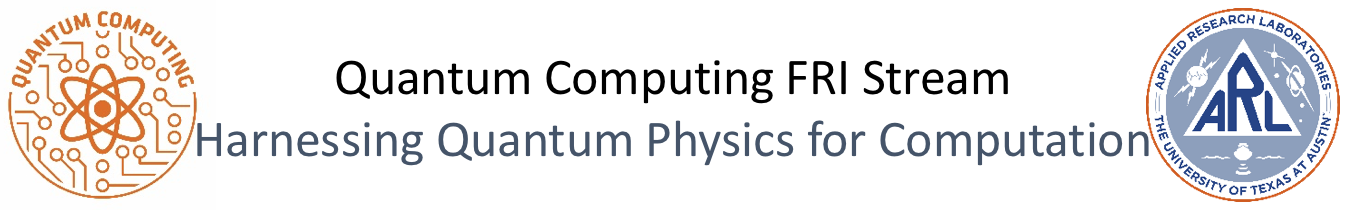

# Fault Tolerance

### Installations and Imports

In [2]:
#In case you don't have qiskit, install it now
%pip install qiskit --quiet
%pip install qiskit-aer --quiet
#Installing/upgrading pylatexenc seems to have fixed my mpl issue
#If you try this and it doesn't work, try also restarting the runtime/kernel
%pip install pylatexenc --quiet

You should consider upgrading via the '/usr/local/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.
You should consider upgrading via the '/usr/local/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.
You should consider upgrading via the '/usr/local/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [3]:
#Let's go ahead and import all this stuff too
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit_aer import Aer
from qiskit.quantum_info import Statevector
import numpy as np
from qiskit.visualization import plot_histogram, plot_bloch_multivector

In [4]:
def rand(a=0, b=1):
    return a + (b-a)*np.random.random()

## Today's Objectives

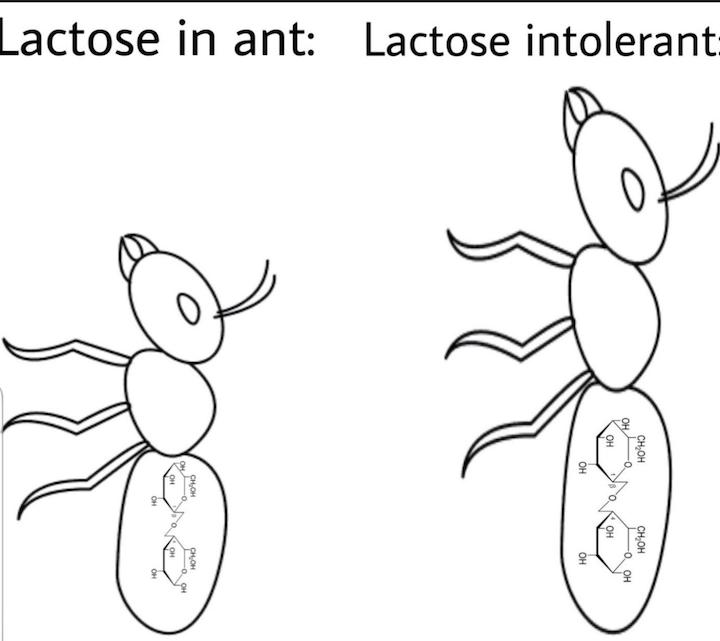

- Examine the Steane Code for transversal gates
- Implement a "T-Gadget"
- Distill a magic state

## Fault Tolerance

The fault-tolerance theorem (better known as the quantum threshold theorem) states that, if an encoding can correct errors more quickly than errors occur, then nested encodings can reduce effective errors to an arbitrarily small rate.

In order for this to work, the rate of error occurance must fall below some threshold which depends on the encoding.

## Transversal Gates

We have discussed encoding qubits with error correcting codes to preserve their states. But we also want to use our qubits for computation, and that requires applying gates.

For the error correcting code to be effective, we want to operate on the qubits while they are still encoded. So we need encoded versions of the gates we wish to apply.

A gate that can be implemented on the encoded state via a series of single-qubit gates is called __transversal__.

The so called "steane" code has a nice set of transversal gates which each consist of applying the same gate to each qubit individually.

## Encoding and Decoding

Execute the cells below for an implementation of a 7-qubit error correcting code. We will use this code to study transversal gates.

In [5]:
def steane_encoding(qc, qx):
    # Encode qubit qx[0] using the seven-qubit "steane" code.
    n=len(qx)
    if n!=7:
      print('qubit register length must be 7')
      return

    qc.h(qx[1])
    qc.h(qx[2])
    qc.h(qx[3])

    qc.cx(qx[3],qx[5])
    qc.cx(qx[2],qx[4])
    qc.cx(qx[1],qx[6])

    qc.cx(qx[0],qx[3])
    qc.cx(qx[0],qx[2])
    qc.cx(qx[0],qx[1])

    qc.cx(qx[4],qx[0])
    qc.cx(qx[5],qx[0])
    qc.cx(qx[6],qx[0])

    qc.cx(qx[1],qx[5])
    qc.cx(qx[2],qx[6])
    qc.cx(qx[3],qx[4])
    return

In [6]:
def steane_decoding(qc, qx):
    # decode qubit qx[0] using the seven-qubit "steane" code.
    n=len(qx)
    if n!=7:
      print('qubit register length must be 7')
      return
    qc.cx(qx[1],qx[5])
    qc.cx(qx[2],qx[6])
    qc.cx(qx[3],qx[4])

    qc.cx(qx[4],qx[0])
    qc.cx(qx[5],qx[0])
    qc.cx(qx[6],qx[0])

    qc.cx(qx[0],qx[3])
    qc.cx(qx[0],qx[2])
    qc.cx(qx[0],qx[1])

    qc.cx(qx[3],qx[5])
    qc.cx(qx[2],qx[4])
    qc.cx(qx[1],qx[6])

    qc.h(qx[1])
    qc.h(qx[2])
    qc.h(qx[3])
    return

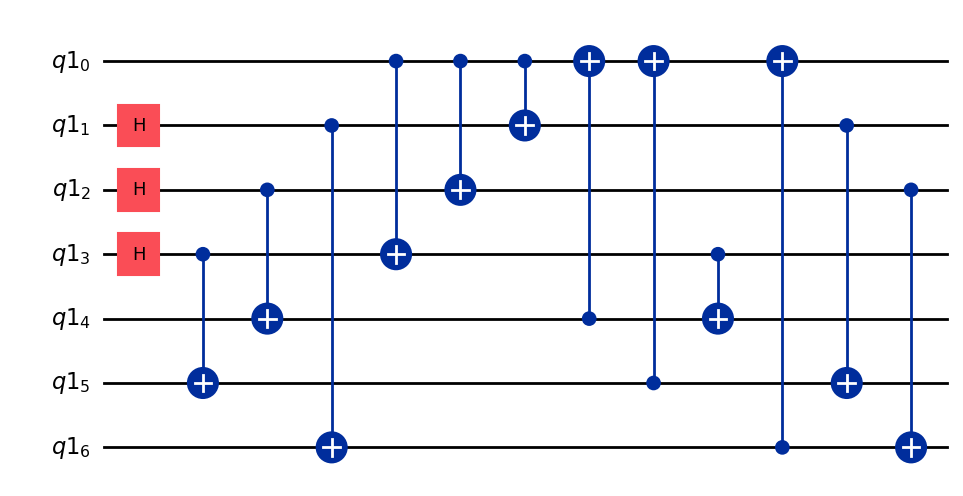

In [7]:
q=QuantumRegister(7)
qc=QuantumCircuit(q)

steane_encoding(qc,q)

qc.draw('mpl')

## Syndrome Measurement

$$\textbf{Stabilizers}$$

$$\begin{align}
\mathbf{M}_{0}=&\mathbf{X}_{0}\mathbf{X}_{1}\mathbf{X}_{5}\mathbf{X}_{6} \\
\mathbf{M}_{1}=&\mathbf{X}_{0}\mathbf{X}_{2}\mathbf{X}_{4}\mathbf{X}_{6} \\
\mathbf{M}_{2}=&\mathbf{X}_{0}\mathbf{X}_{3}\mathbf{X}_{4}\mathbf{X}_{5} \\
\mathbf{M}_{3}=&\mathbf{Z}_{0}\mathbf{Z}_{1}\mathbf{Z}_{5}\mathbf{Z}_{6} \\
\mathbf{M}_{4}=&\mathbf{Z}_{0}\mathbf{Z}_{2}\mathbf{Z}_{4}\mathbf{Z}_{6} \\
\mathbf{M}_{5}=&\mathbf{Z}_{0}\mathbf{Z}_{3}\mathbf{Z}_{4}\mathbf{Z}_{5} \\
\end{align}$$

In [8]:
def steane_syndrome(qc, qx, qs):

    qc.h(qs)
#M0
    qc.cx(qs[0],qx[0])
    qc.cx(qs[0],qx[1])
    qc.cx(qs[0],qx[5])
    qc.cx(qs[0],qx[6])
    qc.barrier()
#M1
    qc.cx(qs[1],qx[0])
    qc.cx(qs[1],qx[2])
    qc.cx(qs[1],qx[4])
    qc.cx(qs[1],qx[6])
    qc.barrier()
#M2
    qc.cx(qs[2],qx[0])
    qc.cx(qs[2],qx[3])
    qc.cx(qs[2],qx[4])
    qc.cx(qs[2],qx[5])
    qc.barrier()
#M3
    qc.cz(qs[3],qx[0])
    qc.cz(qs[3],qx[1])
    qc.cz(qs[3],qx[5])
    qc.cz(qs[3],qx[6])
    qc.barrier()
#M4
    qc.cz(qs[4],qx[0])
    qc.cz(qs[4],qx[2])
    qc.cz(qs[4],qx[4])
    qc.cz(qs[4],qx[6])
    qc.barrier()
#M5
    qc.cz(qs[5],qx[0])
    qc.cz(qs[5],qx[3])
    qc.cz(qs[5],qx[4])
    qc.cz(qs[5],qx[5])
    qc.barrier()

    qc.h(qs)
    return

## Main Code Block

This executes the entire protocol.

We don't actually want to worry about correction at this point. We are interested in finding the transversal gates for this code.

In [9]:
n = 7 # number of physical qubits
k = 1 # number of logical qubits

# prepare the quantum circuit
qx = QuantumRegister(n)
qs = QuantumRegister(n-k)
cx = ClassicalRegister(n)
cs = ClassicalRegister(n-k)
qc = QuantumCircuit(qx, qs, cx, cs)

# prepare a single-qubit state in qx[0] as |0>, |+>, or |R>
#qc.h(qx[0])
#qc.s(qx[0])

# encode the qubit using the 7-qubit code
steane_encoding(qc, qx)
qc.barrier()
#
#USE THIS LOOP TO TEST GATES FOR TRANSVERSALITY
#
# apply a gate to the encoded qubits
for i in range(7):
  qc.t(qx[i]) #Change the Identity gate to test for transversality
qc.barrier()
#


# apply gates to perform a syndrome measurement
steane_syndrome(qc, qx, qs)

# decode the corrected, encoded qubit
steane_decoding(qc, qx)

# prepare qubit qx[0] for measurement
#qc.sdg(qx[0])
#qc.h(qx[0])

# measure the qx register
for i in range(len(qx)):
    qc.measure(qx[i], cx[i])

# measure the qs register
for j in range(len(qs)):
    qc.measure(qs[j], cs[j])

#qc.draw()

# execute the quantum circuit
backend =  Aer.get_backend('qasm_simulator')
job = backend.run(qc, shots=1024)
data = job.result().get_counts(qc)
print(data)

{'000100 0001000': 79, '000011 0000110': 69, '000111 0001110': 61, '000101 0001010': 51, '000001 0000010': 66, '000110 0001100': 63, '000010 0000100': 61, '000000 0000000': 574}


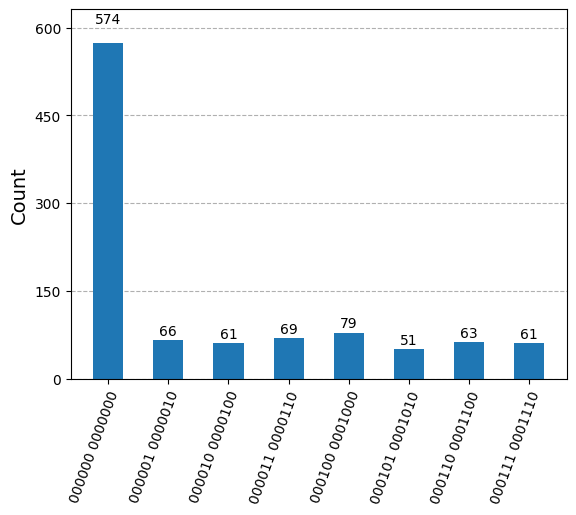

In [10]:
plot_histogram(data)

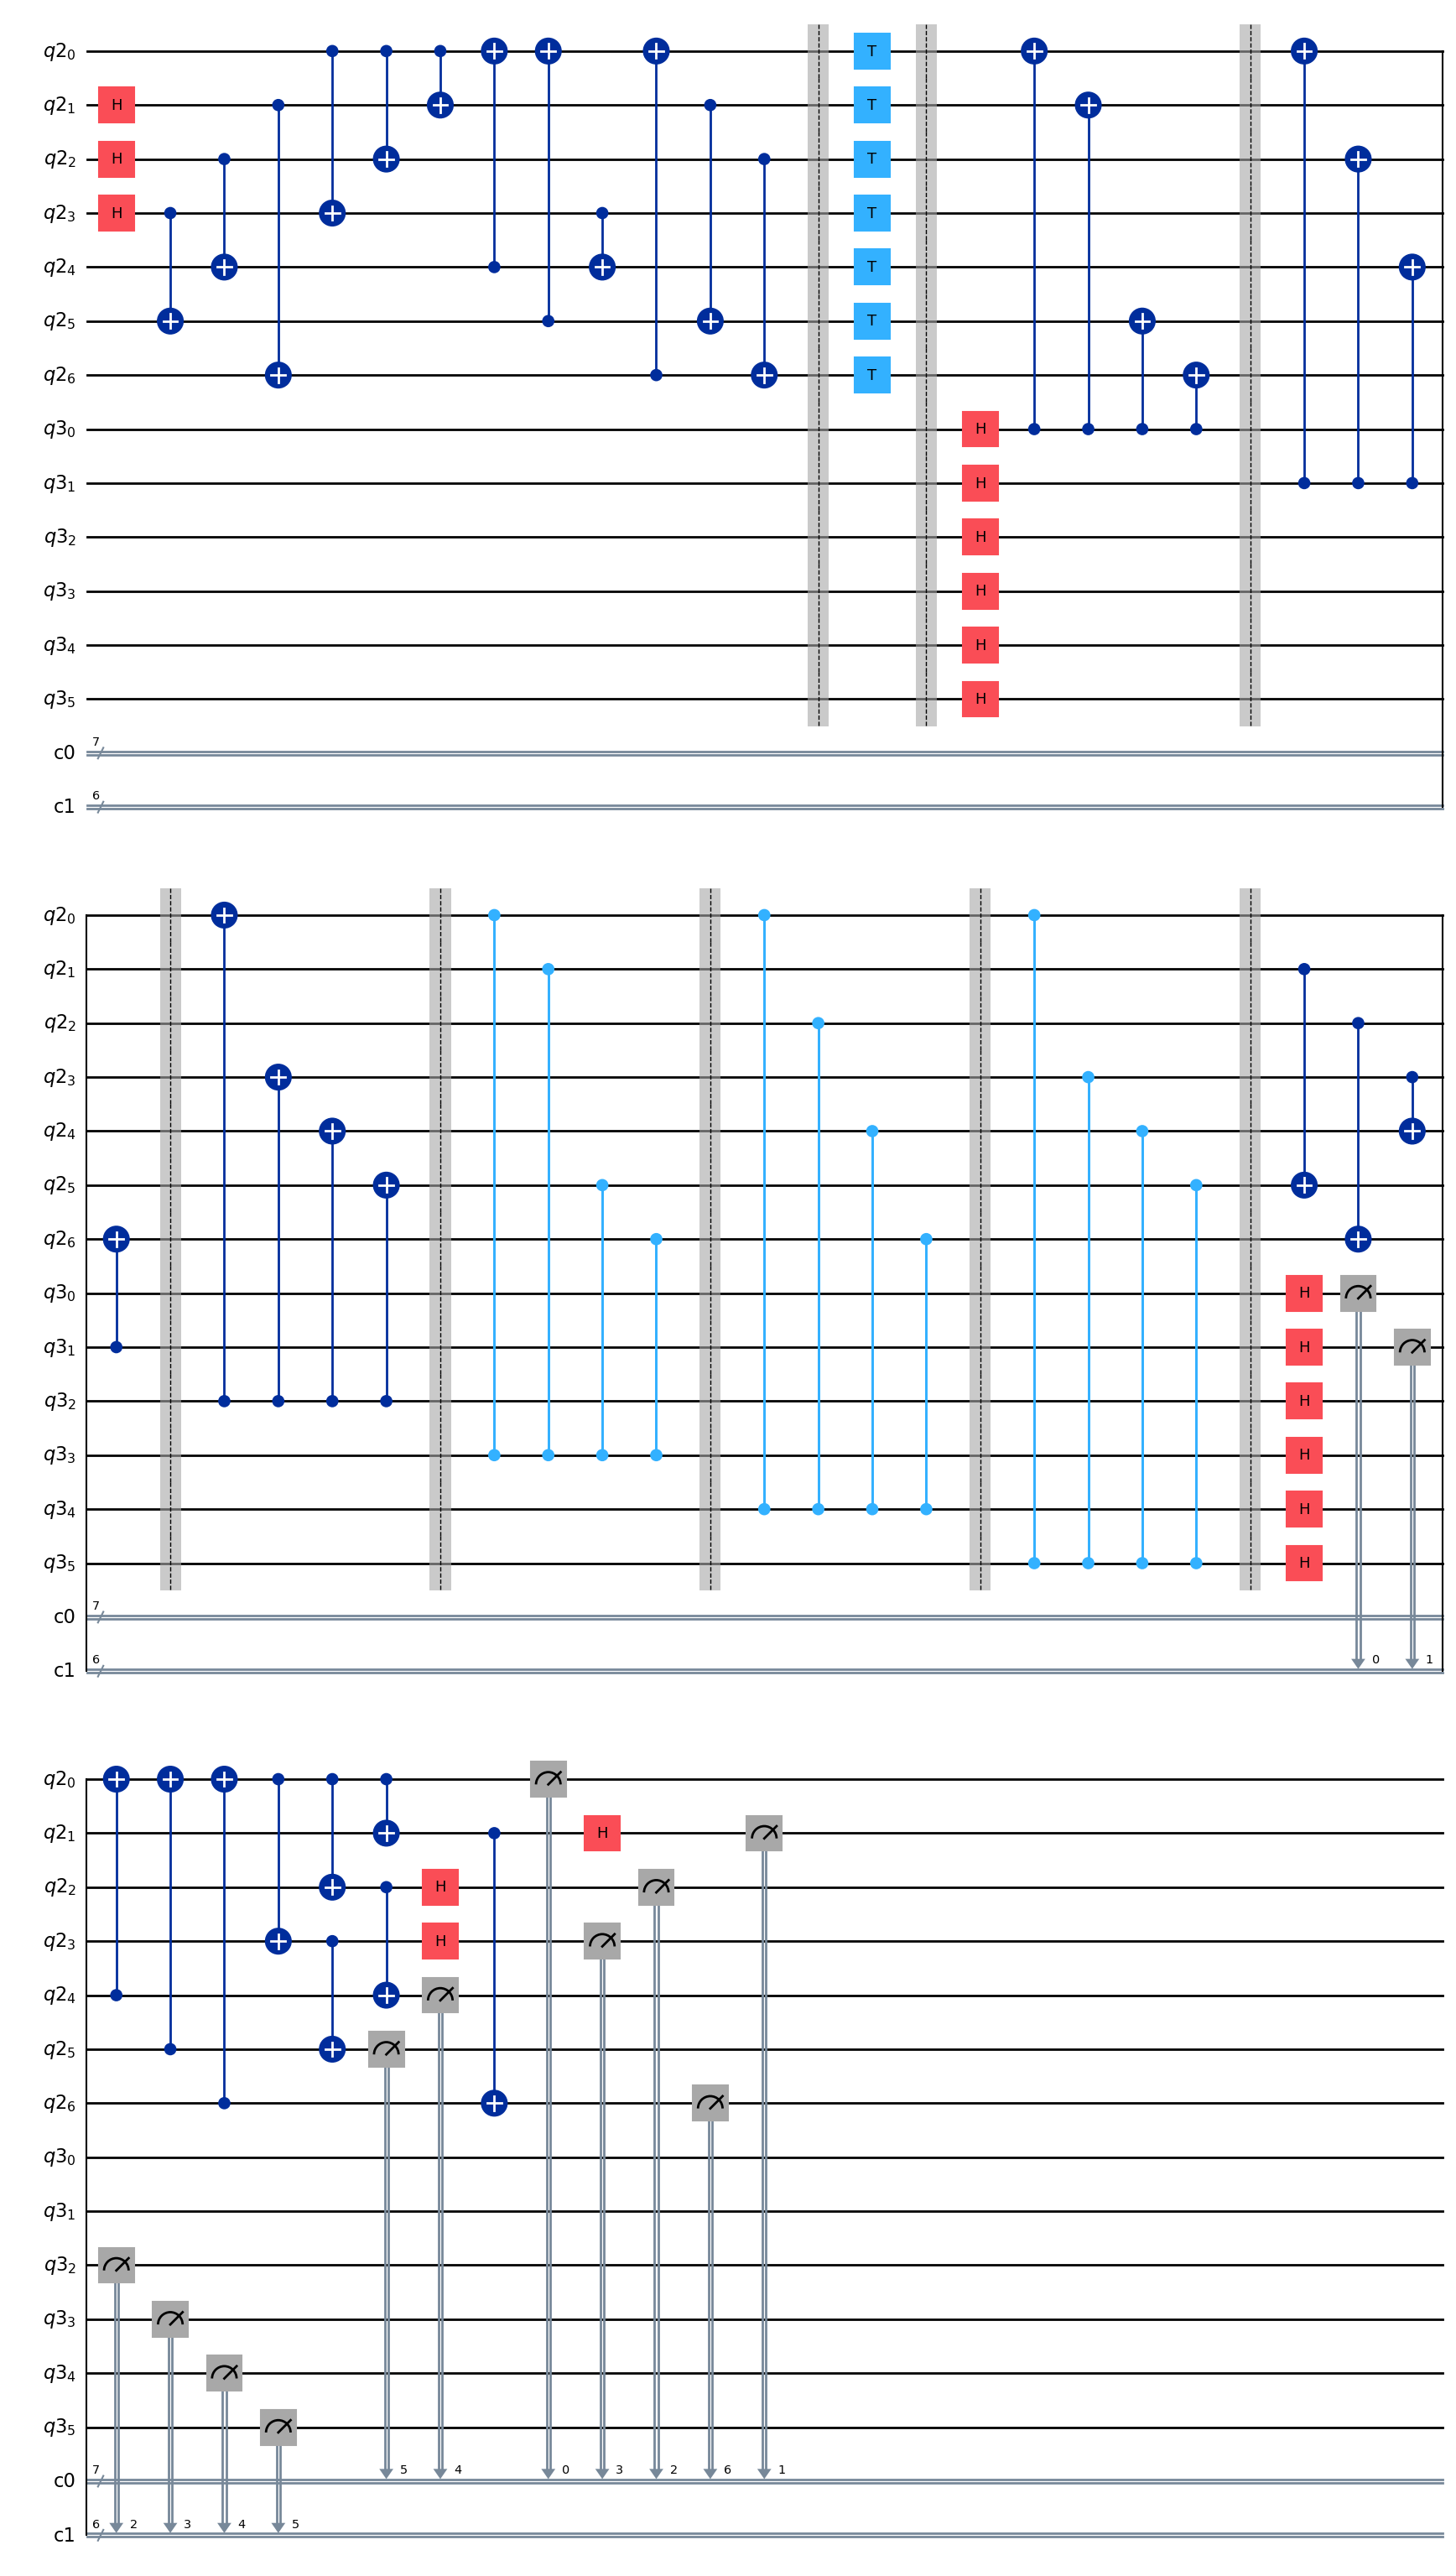

In [11]:
qc.draw('mpl')

### <font color=green> Exercise </font>

Run the main code block above while substituting common gates to apply to the encoded qubits. An error detected in the syndrome measurment indicates an applied gate's non-transversality.

List your transversal gates here:
$X,I,Y,Z,H,S,S^{\dagger}$

List any NON-transversal gates here:
$P_{\frac{\pi}{16}},T,T^{\dagger}$

## Magic State Gadget

Since we cannot apply the T gate directly, we need a way to apply it to our encoded state.

A magic state gadget does just this by preparing the state which would result from application of a T gate and then conditionally injecting it into the circuit.

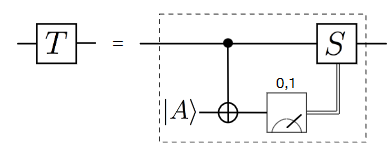

Find the resulting state given an input state of $\lvert \psi \rangle = \alpha\lvert 0\rangle + \beta\lvert 1\rangle$ and for  $\lvert A \rangle = \frac{1}{\sqrt{2}}\left(\lvert 0\rangle + e^{i\pi/4}\lvert 1\rangle\right)$

$$\lvert A\rangle=\mathbf{T}\mathbf{H}\lvert 0 \rangle$$

$$\begin{align*}
\lvert \mathbf{A}\rangle \otimes\lvert \psi\rangle =& \;\frac{1}{\sqrt{2}}\Big(\lvert 0\rangle + e^{i\pi/4}\lvert 1\rangle\Big) \otimes \Big(\alpha\lvert 0\rangle + \beta\lvert 1\rangle\Big) \\
=& \frac{1}{\sqrt{2}}\left(\alpha\lvert 00\rangle+ e^{i\pi/4}\alpha\lvert 10\rangle + \beta\lvert 01\rangle+ e^{i\pi/4}\beta\lvert 11\rangle \right) \\
\xrightarrow{\mathbf{CNOT}}=& \frac{1}{\sqrt{2}}\left(\alpha\lvert 00\rangle+e^{i\pi/4}\alpha \lvert 10\rangle + \beta\lvert 11\rangle+ e^{i\pi/4}\beta\lvert 01\rangle \right) \\
=& \lvert 0 \rangle \otimes \frac{1}{\sqrt{2}}\Big(\alpha\lvert 0\rangle+  e^{i\pi/4}\beta\lvert 1\rangle\Big) + \lvert 1 \rangle \otimes \frac{1}{\sqrt{2}}\Big( e^{i\pi/4}\alpha\lvert 0\rangle+ \beta \lvert 1\rangle\Big)
\end{align*}$$

$\text{So the measurement has 2 possibile outcomes:}$

$\text{If we measure 0 we are left with }\alpha \lvert 0\rangle + e^{i\pi/4}\beta  \lvert 1\rangle \text{ which is the result of applying a }\mathbf{T}\text{ gate.}$

$\text{If we measure 1 we apply the }\mathbf{S}\text{ gate}$

$$\mathbf{S}\left(e^{i\pi/4}\alpha \lvert 0\rangle + \beta \lvert 1\rangle\right)=e^{i\pi/4}\left(\alpha \lvert 0\rangle + e^{i\pi/4}\beta \lvert 1\rangle\right)$$

$\text{which gives the desired state up to a global phase of }e^{i\pi/4}.$

### <font color=green> Exercise </font>

Build a T-gadget as shown in the picture above and compare its effect to the T gate below.

*Hint: Statevector evolution doesn't work with measurement gates, so you may want to replace the measurement and conditional S gate with a controlled S gate.*


#### T Gate Directly

In [24]:
from qiskit.circuit.library.standard_gates import SGate

q=QuantumRegister(2)
c=ClassicalRegister(1)

qc=QuantumCircuit(q,c)
c2S_gate = SGate().control(1)
#state prep
qc.h(q[0])
qc.t(q[0])

qc.draw()

┌───┐┌───┐
q20_0: ┤ H ├┤ T ├
       └───┘└───┘
q20_1: ──────────
                 
c12: 1/══════════

In [54]:
q=QuantumRegister(2)
c=ClassicalRegister(2)
qc=QuantumCircuit(q,c)
qc.h(q[1])
qc.cx(q[0],q[1])
qc.measure(q[0],c[0])
qc.s(q[0]).c_if(c[0],1)
qc.tdg(q[0])
qc.measure(q[1],c[0])
qc.draw()


┌─┐    ┌───┐    ┌─────┐
q31_0: ───────■──┤M├────┤ S ├────┤ Tdg ├
       ┌───┐┌─┴─┐└╥┘    └─╥─┘    └─┬─┬─┘
q31_1: ┤ H ├┤ X ├─╫───────╫────────┤M├──
       └───┘└───┘ ║ ┌─────╨─────┐  └╥┘  
c23: 2/═══════════╩═╡ c23_0=0x1 ╞═══╩═══
                  0 └───────────┘   0

In [55]:
# execute the quantum circuit
backend =  Aer.get_backend('qasm_simulator')
job = backend.run(qc, shots=1024)
data = job.result().get_counts(qc)
print(data)

{'01': 490, '00': 534}


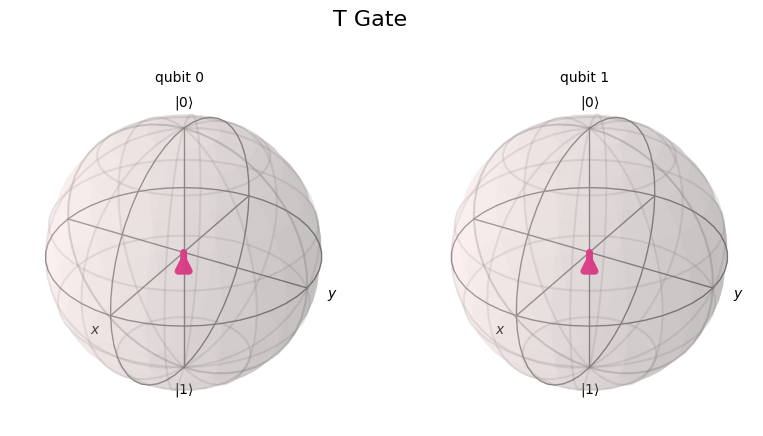

In [19]:
plot_bloch_multivector(Statevector.from_instruction(qc).data,title='T Gate')

In [20]:
#Or we can measure in the appropriate basis to check if the T has been applied
qc.tdg(q)
#Remember to undo our initial state preparation
qc.h(q)
qc.measure(q,c)
qc.draw()

CircuitError: 'register size error'

In [26]:
# execute the quantum circuit
backend =  Aer.get_backend('qasm_simulator')
job = backend.run(qc, shots=1024)
data = job.result().get_counts(qc)
print(data)

AerError: 'unknown instruction: cs'